In [2]:
# Import the pandas library
import pandas as pd

# Load the CSV file into a pandas DataFrame.
# The 'encoding' parameter helps prevent errors with special characters in the data.
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')

# Display the first 5 rows of the data to make sure it loaded correctly.
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Action 1: Get a high-level summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Action 2: Check for missing values quantitatively
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# --- Cleaning Step 1: Remove rows with missing CustomerID ---
# The 'inplace=True' argument modifies the DataFrame directly without needing to reassign it.
df.dropna(subset=['CustomerID'], inplace=True)

# --- Cleaning Step 2: Convert CustomerID to an integer ---
# It's currently a float (e.g., 17850.0), but IDs should be integers.
df['CustomerID'] = df['CustomerID'].astype(int)

# --- Cleaning Step 3: Remove nonsensical data ---
# We only want transactions with a positive quantity and a price greater than zero.
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# --- Cleaning Step 4: Convert InvoiceDate to a proper date format ---
# This allows us to perform calculations with dates, like finding the most recent purchase.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# --- Final check: Verify the changes ---
print("--- After Cleaning ---")
df.info()
print("\nMissing values check after cleaning:")
print(df.isnull().sum())

--- After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.3+ MB

Missing values check after cleaning:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [6]:
# Create a 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [7]:
# Set a snapshot date for recency calculation. We'll use the day after the last transaction.
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Snapshot Date: {snapshot_date}")

# Group by customer ID and calculate RFM metrics
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # Recency
    'InvoiceNo': 'nunique', # Frequency (counting unique invoices)
    'TotalPrice': 'sum' # Monetary
})

# Rename the columns for clarity
rfm_df.rename(columns={'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'TotalPrice': 'MonetaryValue'}, inplace=True)

# Display the first 5 rows of our new RFM table
rfm_df.head()

Snapshot Date: 2011-12-10 12:50:00


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [8]:
# Calculate Average Order Value
rfm_df['AOV'] = rfm_df['MonetaryValue'] / rfm_df['Frequency']

# Display the first 5 rows with the new AOV column
rfm_df.head()

,Recency,Frequency,MonetaryValue,AOV
CustomerID,,,,
12346,326,1,77183.60,77183.600000
12347,2,7,4310.00,615.714286
12348,75,4,1797.24,449.310000
12349,19,1,1757.55,1757.550000
12350,310,1,334.40,334.400000


In [10]:
# --- Define the time periods ---
analysis_date = pd.to_datetime('2011-09-01')
prediction_date_end = pd.to_datetime('2011-12-01')

# --- Create the feature set from the analysis period ---
features_df = df[df['InvoiceDate'] < analysis_date]
snapshot_date_features = features_df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm_features = features_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date_features - date.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm_features.rename(columns={'InvoiceDate': 'Recency',
                             'InvoiceNo': 'Frequency',
                             'TotalPrice': 'MonetaryValue'}, inplace=True)
rfm_features['AOV'] = rfm_features['MonetaryValue'] / rfm_features['Frequency']

# --- Create the target set (LTV) from the prediction period ---
target_df = df[(df['InvoiceDate'] >= analysis_date) & (df['InvoiceDate'] < prediction_date_end)]

ltv_target = target_df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
ltv_target.rename(columns={'TotalPrice': 'LTV_3M'}, inplace=True)

# --- Merge features and target into a final modeling dataset ---
final_df = rfm_features.merge(ltv_target, on='CustomerID', how='left')

# === THIS IS THE CORRECTED LINE ===
# Fill missing LTV values with 0 for customers who didn't purchase in the prediction period.
final_df['LTV_3M'] = final_df['LTV_3M'].fillna(0)

# Display the first 5 rows of our final dataset for the model
final_df.head()

,CustomerID,Recency,Frequency,MonetaryValue,AOV,LTV_3M
0,12346,226,1,77183.60,77183.600000,0.00
1,12347,30,5,2790.86,558.172000,1294.32
2,12348,149,3,1487.24,495.746667,310.00
3,12350,211,1,334.40,334.400000,0.00
4,12352,163,5,1561.81,312.362000,944.23


In [11]:
# Import the function from scikit-learn
from sklearn.model_selection import train_test_split

# Define our features (X) and target (y)
# X should contain all the features we want the model to learn from.
# We drop the LTV target and the CustomerID, which is just an identifier.
X = final_df.drop(['LTV_3M', 'CustomerID'], axis=1)

# y is the column we want to predict.
y = final_df['LTV_3M']

# Perform the split
# test_size=0.2 means 20% of the data will be used for testing.
# random_state=42 ensures that we get the same split every time we run the code.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the new dataframes to see the split in action
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2653, 4)
Shape of X_test: (664, 4)
Shape of y_train: (2653,)
Shape of y_test: (664,)


In [12]:
# Import the XGBoost Regressor model
import xgboost as xgb

# Create an instance of the XGBoost Regressor
# We can start with some basic parameters:
# n_estimators: The number of decision trees to build.
# learning_rate: How much each new tree corrects the previous ones.
# max_depth: The maximum depth of each tree.
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)

# Train the model on our training data
# This is where the model "learns" the patterns.
model.fit(X_train, y_train)

print("XGBoost model has been trained successfully!")

XGBoost model has been trained successfully!


In [13]:
# Import the metrics functions from scikit-learn and numpy for the square root
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the results in a clear, understandable format
print("--- Model Performance on Test Data ---")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

--- Model Performance on Test Data ---
Mean Absolute Error (MAE): $848.10
Root Mean Squared Error (RMSE): $4832.37


In [14]:
# Create a new DataFrame to store the results for easy analysis
results_df = X_test.copy()
results_df['Actual_LTV'] = y_test
results_df['Predicted_LTV'] = y_pred

# Define the quantile boundaries for segmentation
quantiles = results_df['Predicted_LTV'].quantile([0.25, 0.75])
low_threshold = quantiles[0.25]
high_threshold = quantiles[0.75]

# Create the 'Segment' column based on the predicted LTV
def segment_customer(predicted_ltv):
    if predicted_ltv <= low_threshold:
        return 'Low Value'
    elif predicted_ltv <= high_threshold:
        return 'Mid Value'
    else:
        return 'High Value'

results_df['Segment'] = results_df['Predicted_LTV'].apply(segment_customer)

# Display the first 10 rows with the new Segment column
print("--- Results with Customer Segments ---")
print(results_df.head(10))

# Display the count of customers in each segment
print("\n--- Customer Count per Segment ---")
print(results_df['Segment'].value_counts())

--- Results with Customer Segments ---
      Recency  Frequency  MonetaryValue         AOV  Actual_LTV  \
3095      212          3         602.84  200.946667        0.00   
3309      167          1         111.95  111.950000      171.20   
240        80          1         236.26  236.260000        0.00   
2555       78          2         319.47  159.735000      189.34   
2927       25          2         909.55  454.775000     3104.73   
2011      269          1          56.25   56.250000        0.00   
527        13          3         270.40   90.133333        0.00   
1674      239          1         119.30  119.300000        0.00   
3306       59          1         488.55  488.550000      312.96   
3068       29          8         821.60  102.700000       79.60   

      Predicted_LTV    Segment  
3095      85.886841  Low Value  
3309      30.977623  Low Value  
240      122.472458  Low Value  
2555     644.484192  Mid Value  
2927     486.632751  Mid Value  
2011      58.854904  Low 

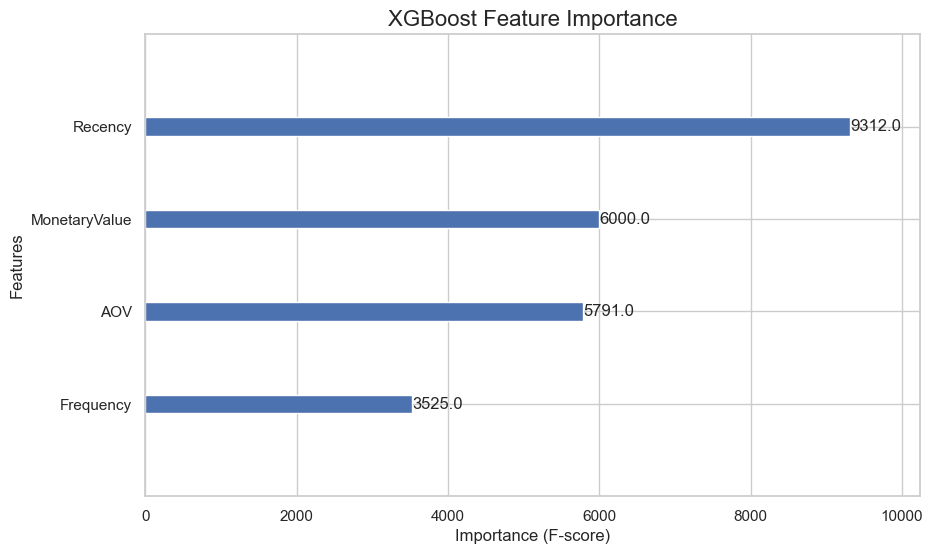

In [15]:
# Import the necessary libraries for plotting
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Create the feature importance plot
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax, importance_type='weight')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance (F-score)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

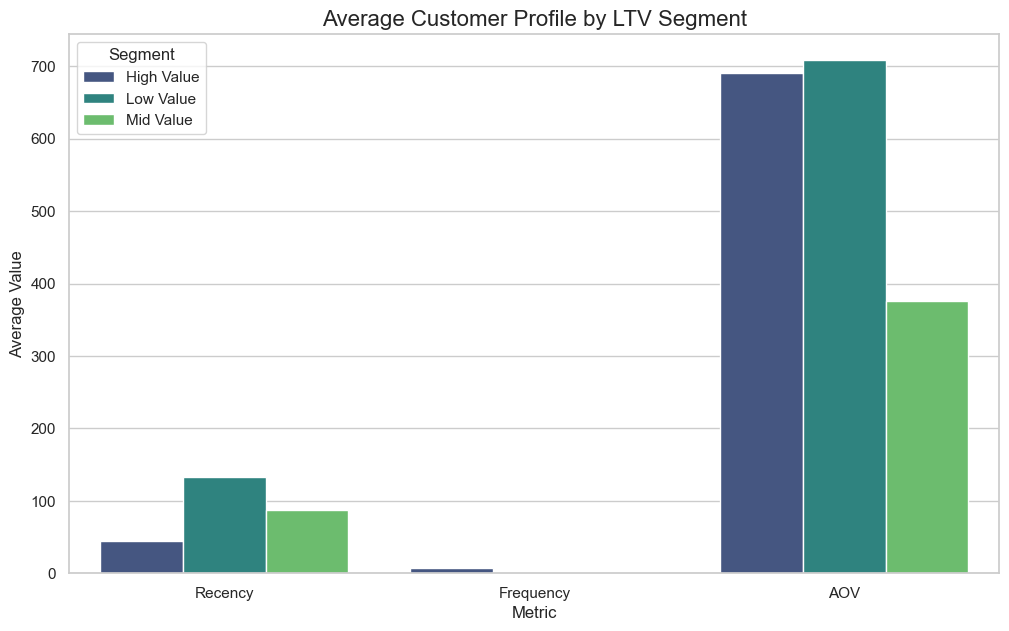

In [16]:
# Calculate the average RFM-AOV values for each segment
segment_profiles = results_df.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'AOV': 'mean'
}).reset_index()

# Melt the DataFrame for easier plotting with seaborn
segment_profiles_melted = segment_profiles.melt(id_vars='Segment', var_name='Metric', value_name='Average Value')

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=segment_profiles_melted, x='Metric', y='Average Value', hue='Segment', palette='viridis')
plt.title('Average Customer Profile by LTV Segment', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Segment')
plt.show()

In [17]:
# Import the joblib library
import joblib

# Save the trained model to a file
# The filename 'ltv_xgboost_model.pkl' is a common convention
joblib.dump(model, 'ltv_xgboost_model.pkl')

print("Model saved successfully as 'ltv_xgboost_model.pkl'")

Model saved successfully as 'ltv_xgboost_model.pkl'


In [19]:
# Create a final dataframe with all the necessary features plus CustomerID
# === THIS IS THE CORRECTED LINE ===
final_predictions_df = final_df[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue', 'AOV']].copy()

# The features we want to predict on must match the training features
features_for_prediction = final_predictions_df.drop('CustomerID', axis=1)

# Use our trained model to predict LTV for all these customers
all_predictions = model.predict(features_for_prediction)

# Add the predictions to the dataframe
final_predictions_df['Predicted_LTV_3M'] = all_predictions

# Select only the columns we need for the final report
output_df = final_predictions_df[['CustomerID', 'Predicted_LTV_3M']]

# Save the final predictions to a CSV file
output_df.to_csv('customer_ltv_predictions.csv', index=False)

print("Final predictions saved to 'customer_ltv_predictions.csv'")
print("\n--- First 5 rows of the final CSV output ---")
print(output_df.head())

Final predictions saved to 'customer_ltv_predictions.csv'

--- First 5 rows of the final CSV output ---
   CustomerID  Predicted_LTV_3M
0       12346         59.828640
1       12347       1246.913086
2       12348        474.036377
3       12350         40.118580
4       12352        781.464050
